<a href="https://colab.research.google.com/github/noursalloum5/Project-Disease-detection-from-Chest-X-Ray/blob/main/Disease_detection_from_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Downloading the dataset from kaggle
!pip install opendatasets
import opendatasets as od


od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: noursalloum5
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:20<00:00, 120MB/s]


In [4]:
from pathlib import Path

base_dir = Path("chest-xray-pneumonia/chest_xray/")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"


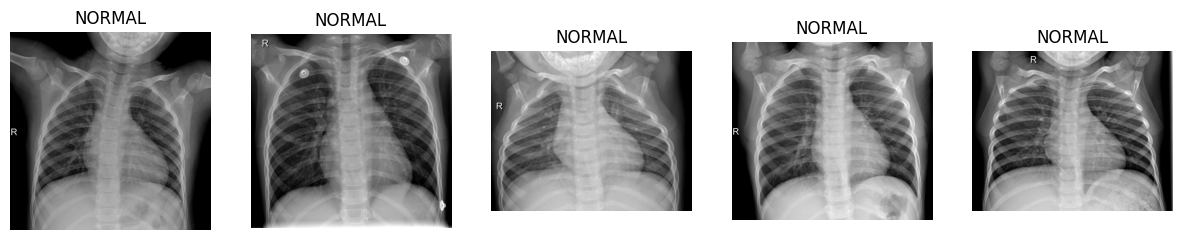

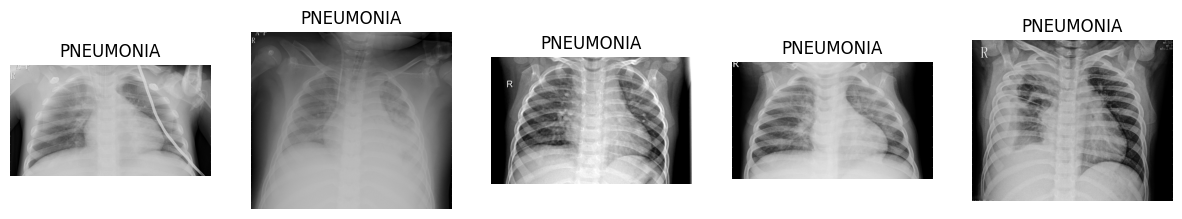

In [4]:
#Visualizing som X-ray images
def plot_samples(class_name, dataset_dir, num_samples=5):
    folder = dataset_dir / class_name
    images = random.sample(os.listdir(folder), num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(images):
        img_path = folder / img_file
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.show()

plot_samples('NORMAL', train_dir)
plot_samples('PNEUMONIA', train_dir)



In [5]:
Img_size=224
Batch_size=32

In [6]:
# Data augmentation and preprocessing for training data
train_gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

In [7]:
# Preprocessing for validation and test data
val_test_gen=ImageDataGenerator(rescale=1./255)

In [8]:
# Load and preprocess training data from directory with augmentation and rescaling
train_data=train_gen.flow_from_directory(
    train_dir,
    target_size=(Img_size,Img_size),
    batch_size=Batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [9]:
# Load and preprocess validating data from directory with augmentation and rescaling
val_data=val_test_gen.flow_from_directory(
    val_dir,
    target_size=(Img_size,Img_size),
    batch_size=Batch_size,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [10]:
# Load and preprocess testing data from directory with augmentation and rescaling
test_data=val_test_gen.flow_from_directory(
    test_dir,
    target_size=(Img_size,Img_size),
    batch_size=Batch_size,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [11]:
model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(Img_size,Img_size,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,425 (18.28 MB)

 Trainable params: 4,791,425 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

**Building and Training a Basic CNN Model**

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history=model.fit(train_data,validation_data=val_data,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 595ms/step - accuracy: 0.7274 - loss: 0.7647 - val_accuracy: 0.7500 - val_loss: 0.6225
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.8975 - loss: 0.2538 - val_accuracy: 0.6875 - val_loss: 0.6522
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9065 - loss: 0.2362 - val_accuracy: 0.7500 - val_loss: 0.5318
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.9295 - loss: 0.1887 - val_accuracy: 0.6250 - val_loss: 0.9936
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.9107 - loss: 0.2291 - val_accuracy: 0.6250 - val_loss: 0.9846
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 610ms/step - accuracy: 0.9177 - loss: 0.2057 - val_accuracy: 0.6250 - val_loss: 1.3064
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9353 - loss: 0.1777 - val_accuracy: 0.6250 - val_loss: 1.2251
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9289 - loss: 

**Building and Training using MobileNetV2**

In [13]:
base_model=MobileNetV2(
    input_shape=(Img_size,Img_size,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
output=layers.Dense(1,activation='sigmoid')(x)
mobilenet_model =models.Model(inputs=base_model.input, outputs=output)

In [15]:
mobilenet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history=mobilenet_model.fit(train_data,validation_data=val_data,epochs=15)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.8236 - loss: 0.3763 - val_accuracy: 0.6250 - val_loss: 0.5295
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9334 - loss: 0.1736 - val_accuracy: 0.7500 - val_loss: 0.4066
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9409 - loss: 0.1454 - val_accuracy: 0.8125 - val_loss: 0.3954
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9496 - loss: 0.1336 - val_accuracy: 0.8125 - val_loss: 0.5495
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.9499 - loss: 0.1259 - val_accuracy: 0.8125 - val_loss: 0.3729
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.9563 - loss: 0.1215 - val_accuracy: 0.7500 - val_loss: 0.3564
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.9566 - loss: 0.1102 - val_accuracy: 0.8125 - val_loss: 0.3910
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9631 - loss: 

**Classification report and confusion matrix**

In [25]:
y_pred=((mobilenet_model.predict(test_data))>0.5).astype("int32")
y_true=test_data.classes

print(classification_report(y_true,y_pred))



20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
              precision    recall  f1-score   support

           0       0.90      0.81      0.86       234
           1       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [26]:
confusion_matrix(y_true,y_pred)

array([[190,  44],
       [ 20, 370]])

**Visualize training vs validation performance (loss & accuracy curves)**

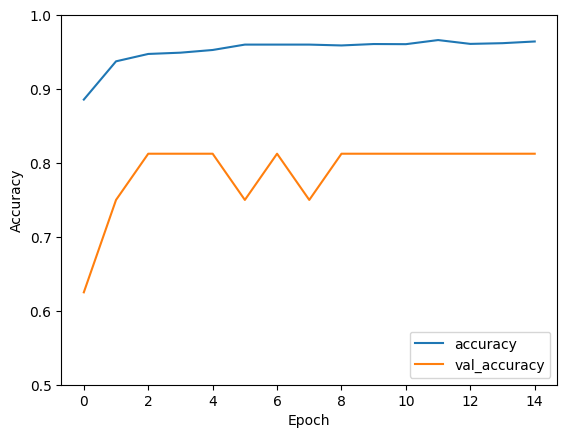

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'] , label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


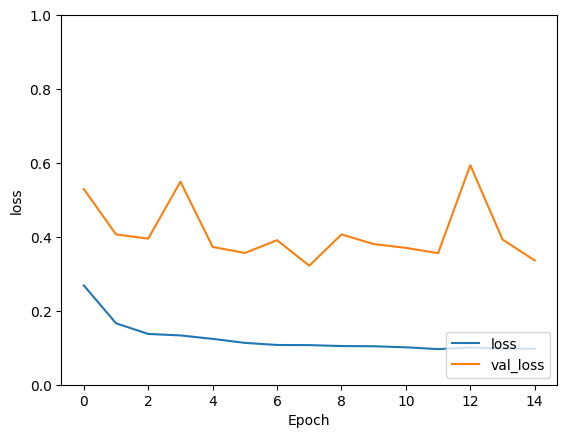

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'] , label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
